In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = r"C:\Users\nitee\Downloads\archive (17)\Banana Disease Recognition Dataset\Augmented images\Augmented images"
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

In [4]:
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), subset='validation')

Found 2287 images belonging to 7 classes.
Found 569 images belonging to 7 classes.


In [5]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [6]:
class_weights

{0: 0.868920972644377,
 1: 1.1668367346938775,
 2: 0.6778304682868999,
 3: 0.6778304682868999,
 4: 1.060760667903525,
 5: 1.4204968944099379,
 6: 2.532668881506091}

In [7]:
def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

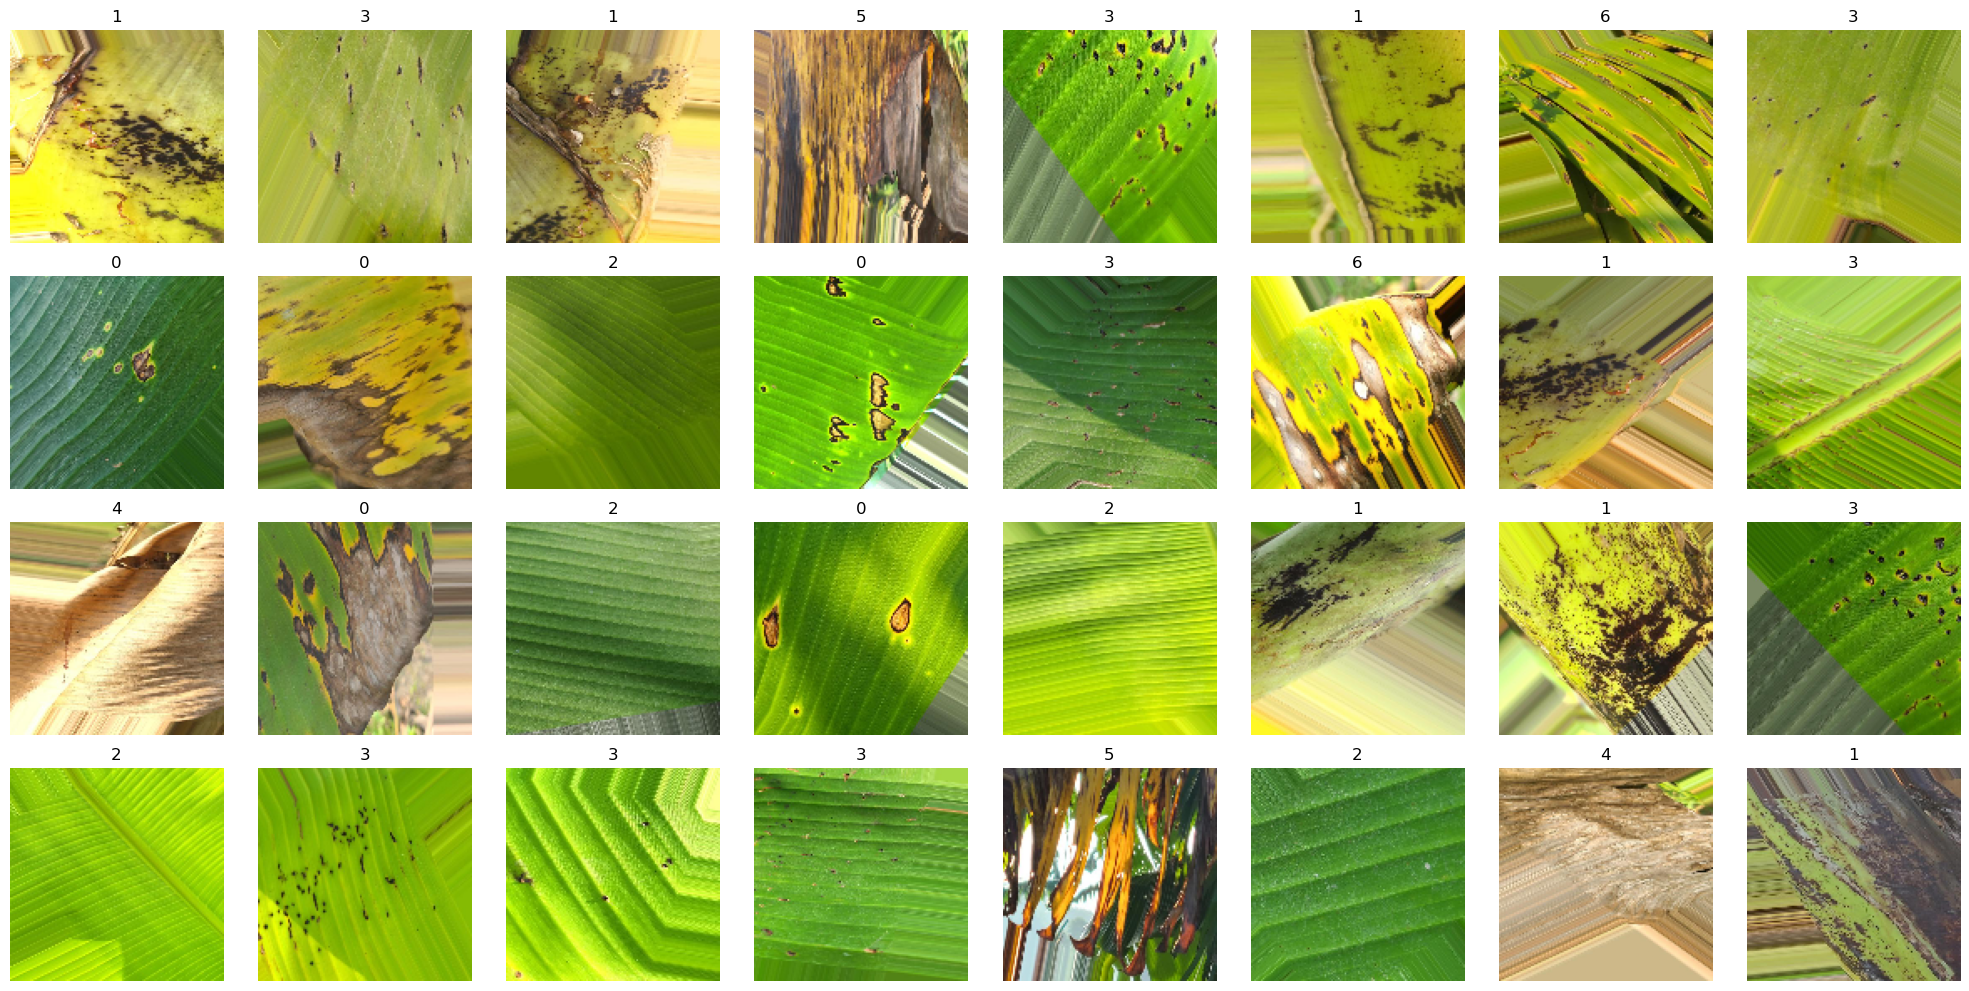

In [8]:
images, labels = next(train_generator)
plot_images(images, labels)


In [9]:
from scipy.ndimage import sobel

def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

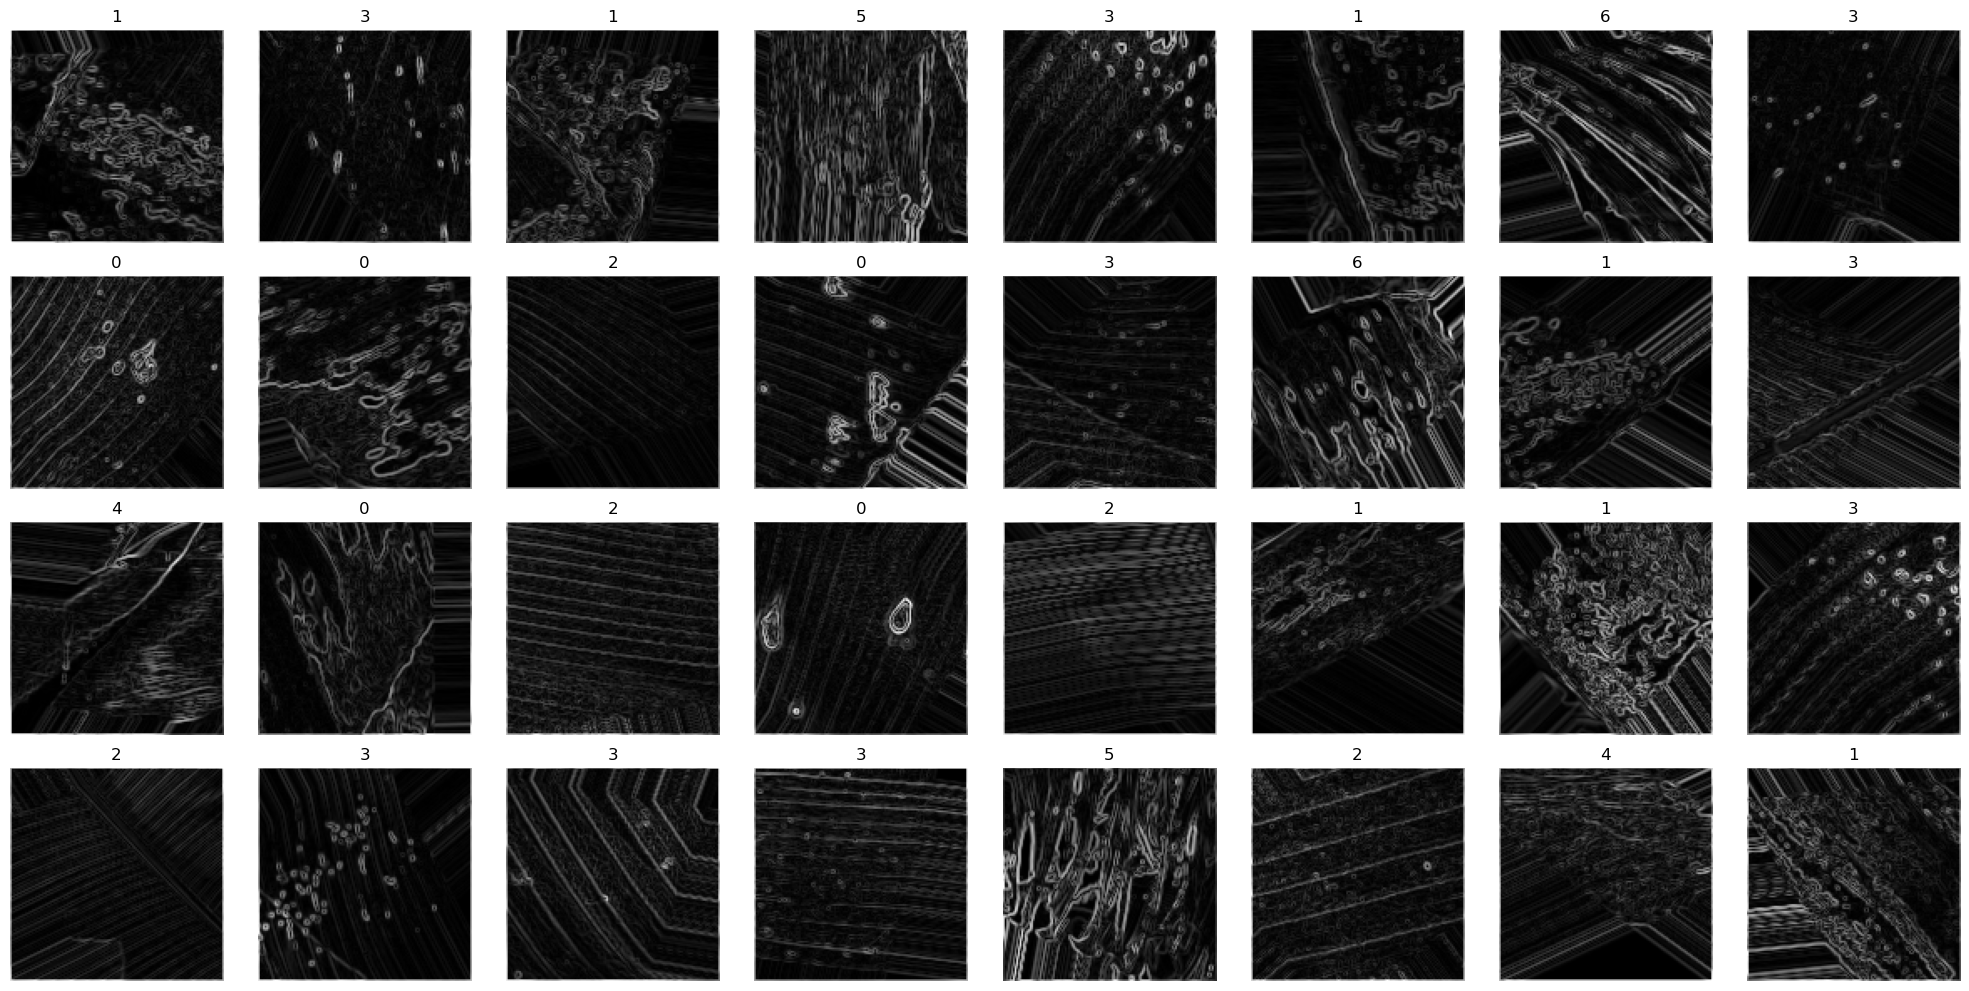

In [10]:
def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)

In [11]:
type(train_generator)

keras.src.preprocessing.image.DirectoryIterator

In [12]:
model_lenet = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')  
])


In [13]:
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [14]:
history_lenet = model_lenet.fit(train_generator, epochs=50, validation_data=val_generator, class_weight=class_weights)


Epoch 1/50
72/72 [==============================] - 177s 2s/step - loss: 2.1177 - accuracy: 0.3328 - precision: 0.3829 - recall: 0.2510 - val_loss: 3.7205 - val_accuracy: 0.2109 - val_precision: 0.2113 - val_recall: 0.2109
Epoch 2/50
72/72 [==============================] - 184s 3s/step - loss: 1.6341 - accuracy: 0.4386 - precision: 0.4952 - recall: 0.3572 - val_loss: 2.7802 - val_accuracy: 0.2302 - val_precision: 0.2423 - val_recall: 0.2074
Epoch 3/50
72/72 [==============================] - 164s 2s/step - loss: 1.4661 - accuracy: 0.4814 - precision: 0.5365 - recall: 0.3852 - val_loss: 2.3400 - val_accuracy: 0.3972 - val_precision: 0.1818 - val_recall: 0.0492
Epoch 4/50
72/72 [==============================] - 166s 2s/step - loss: 1.3205 - accuracy: 0.4998 - precision: 0.5586 - recall: 0.3983 - val_loss: 2.6220 - val_accuracy: 0.2109 - val_precision: 0.2248 - val_recall: 0.2074
Epoch 5/50
72/72 [==============================] - 168s 2s/step - loss: 1.2378 - accuracy: 0.5352 - precisi

In [15]:
def plot_performance(history, title):
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

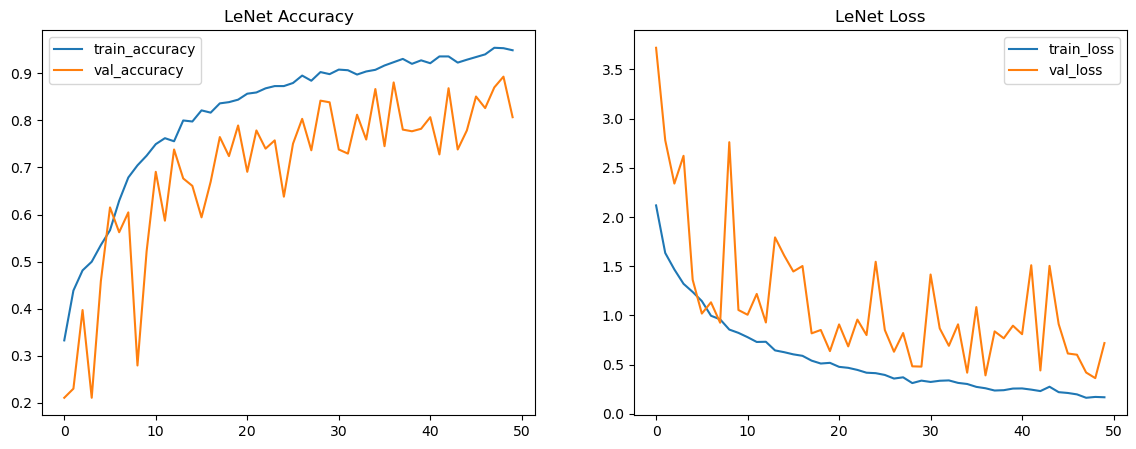

In [16]:
plot_performance(history_lenet, 'LeNet')

In [17]:
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=generator.class_indices)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print('Classification Report:')
    print(cr)

18/18 [==============================] - 10s 500ms/step


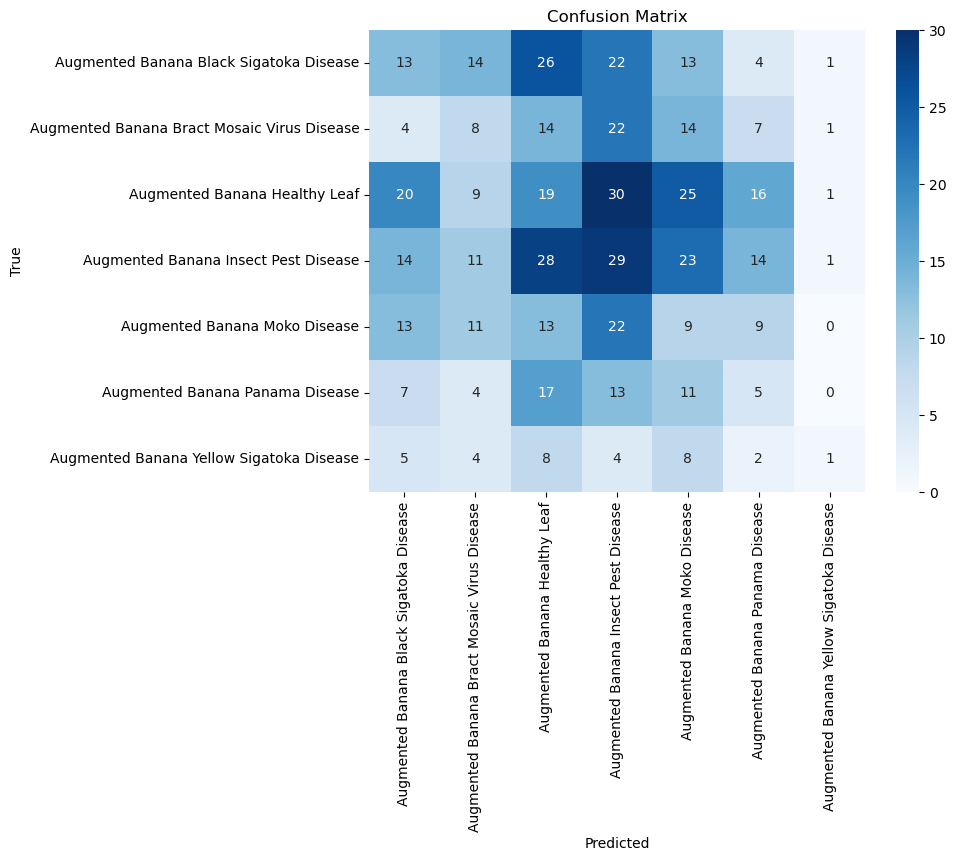

Classification Report:
                                             precision    recall  f1-score   support

    Augmented Banana Black Sigatoka Disease       0.17      0.14      0.15        93
Augmented Banana Bract Mosaic Virus Disease       0.13      0.11      0.12        70
              Augmented Banana Healthy Leaf       0.15      0.16      0.16       120
       Augmented Banana Insect Pest Disease       0.20      0.24      0.22       120
              Augmented Banana Moko Disease       0.09      0.12      0.10        77
            Augmented Banana Panama Disease       0.09      0.09      0.09        57
   Augmented Banana Yellow Sigatoka Disease       0.20      0.03      0.05        32

                                   accuracy                           0.15       569
                                  macro avg       0.15      0.13      0.13       569
                               weighted avg       0.15      0.15      0.14       569



In [18]:
evaluate_model(model_lenet, val_generator)

In [30]:
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

class_mapping = {
    0: "Banana Black Sigatoka Disease",
    1: "Banana Bract Mosaic Virus Disease",
    2: "Banana Healthy Leaf",
    3: "Banana Insect Pest Disease",
    4: "Banana Moko Disease",
    5: "Banana Panama Disease",
    6: "Banana Yellow Sigatoka Disease"
}

def predict_with_lenet(image_path):
    input_size = (128, 128)
    img_lenet = preprocess_image(image_path, input_size)
    pred_lenet = model_lenet.predict(img_lenet)
    final_pred_class = np.argmax(pred_lenet, axis=1)
    final_pred_disease = [class_mapping[class_index] for class_index in final_pred_class]
    return final_pred_disease

image_path = r"C:\Users\nitee\Downloads\archive (17)\Banana Disease Recognition Dataset\Augmented images\Augmented images\Augmented Banana Panama Disease\Augmented Banana Panama Disease (99).jpg"
predicted_class = predict_with_lenet(image_path)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 50ms/step
Predicted Class: ['Banana Panama Disease']


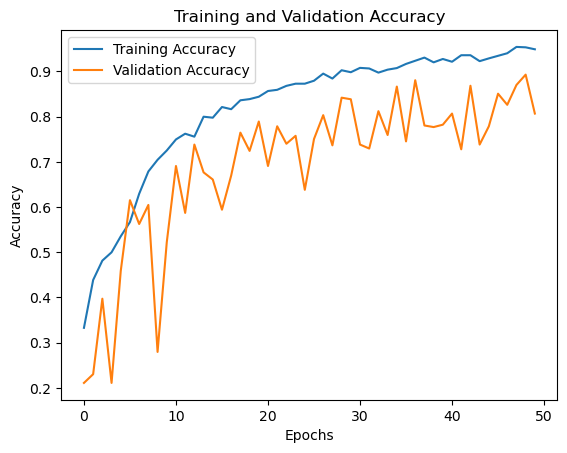

Final Training Accuracy: 0.95
Final Validation Accuracy: 0.81


In [20]:

plt.plot(history_lenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_lenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


train_acc = history_lenet.history['accuracy'][-1]
val_acc = history_lenet.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_acc:.2f}")
print(f"Final Validation Accuracy: {val_acc:.2f}")


Severity Score: 70.00


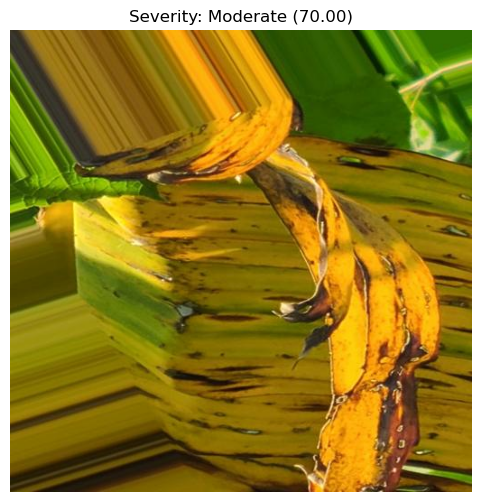

In [72]:
import cv2
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

redness = ctrl.Antecedent(np.arange(0, 256, 1), 'redness')
texture = ctrl.Antecedent(np.arange(0, 101, 1), 'texture')
severity = ctrl.Consequent(np.arange(0, 101, 1), 'severity')

redness['low'] = fuzz.trimf(redness.universe, [0, 0, 85])
redness['mild'] = fuzz.trimf(redness.universe, [50, 128, 200])
redness['severe'] = fuzz.trimf(redness.universe, [170, 255, 255])

texture['smooth'] = fuzz.trimf(texture.universe, [0, 0, 50])
texture['moderate'] = fuzz.trimf(texture.universe, [25, 50, 75])
texture['rough'] = fuzz.trimf(texture.universe, [50, 100, 100])

severity['low'] = fuzz.trimf(severity.universe, [0, 0, 30])
severity['mild'] = fuzz.trimf(severity.universe, [20, 50, 70])
severity['moderate'] = fuzz.trimf(severity.universe, [50, 70, 90])
severity['severe'] = fuzz.trimf(severity.universe, [80, 100, 100])

rule1 = ctrl.Rule(redness['low'] & texture['smooth'], severity['low'])
rule2 = ctrl.Rule(redness['mild'] & texture['moderate'], severity['mild'])
rule3 = ctrl.Rule(redness['severe'] & texture['rough'], severity['severe'])
rule4 = ctrl.Rule(redness['mild'] & texture['smooth'], severity['moderate'])

severity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
severity_sim = ctrl.ControlSystemSimulation(severity_ctrl)

def analyze_image(image_path):
    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    red_channel = hsv_img[:, :, 2].mean()
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gradient = cv2.Laplacian(gray_img, cv2.CV_64F).var()
    texture_score = min(100, gradient / 10)
    return img, red_channel, texture_score

def classify_severity(image_path):
    img, red_channel, texture_score = analyze_image(image_path)
    severity_sim.input['redness'] = red_channel
    severity_sim.input['texture'] = texture_score
    severity_sim.compute()
    severity_value = severity_sim.output['severity']
    print(f"Severity Score: {severity_value:.2f}")
    
    if severity_value < 30:
        severity_label = "Low"
    elif severity_value < 50:
        severity_label = "Mild"
    elif severity_value < 80:
        severity_label = "Moderate"
    else:
        severity_label = "Severe"
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Severity: {severity_label} ({severity_value:.2f})")
    plt.show()

image_path = r"C:\Users\nitee\Downloads\archive (17)\Banana Disease Recognition Dataset\Augmented images\Augmented images\Augmented Banana Panama Disease\Augmented Banana Panama Disease (89).jpg"
classify_severity(image_path)
